# 학습된 딥러닝 모델을 사용하는 예제
- 우리의 궁극적인 목적은 학습이 완료된 모델을 실제로 활용하는 것입니다. 실습에서 경험했듯이 모델을 학습하는 것은 시간이 많이 들고 번거로운 작업입니다. 우리는 매번 모델을 사용하기 위해 학습을 시킬 필요는 없을 것입니다. 학습이 완료되었을 때 학습된 파라미터를 저장하여, 파라미터들만을 불러오면 훈련에 사용한 데이터가 없어도 우리는 모델을 복원할 수 있습니다. 이번 실습에서는 저장된 파라미터를 불러와서 새로운 데이터를 테스트하고 결과를 분석하는 연습을 해봅니다.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms

In [2]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Model 설정

In [3]:
transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((256,256)), transforms.ToTensor()])
tgtnames = ('normal','opacity')
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(), # sigmoid -> relu for our data
    nn.AvgPool2d(kernel_size=2, stride=2), 

    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding = 0),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    Flatten(),
    nn.Linear(in_features=16*(62)*(62), out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2) # 0: normal, 1: opacity 
)
net.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

## 학습된 파라미터를 불러오기

In [4]:
net.load_state_dict(torch.load('/content/drive/My Drive/hufs/RSNA2019/lenet5_rsna2019_256x256_v20200525'))


<All keys matched successfully>

#  단일 데이터에 대한 테스트

Text(0.5, 1.0, 'prediction: opacity')

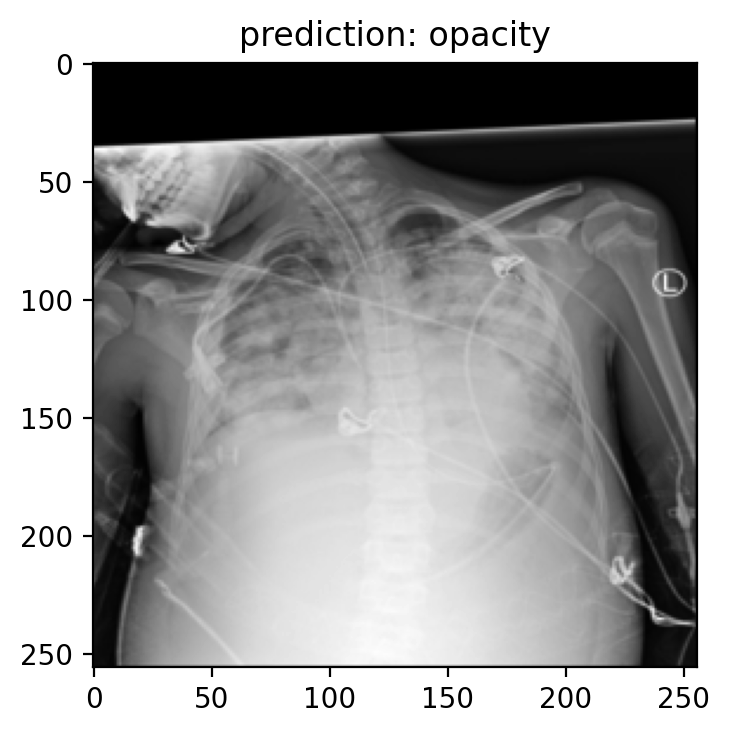

In [5]:
imgurl = '/content/drive/My Drive/hufs/rsna2019_4500/500/opacity/e48a77e5-d627-41c2-b82d-30677644e885.png'
img = Image.open(imgurl)
imgt = transform(img).float().unsqueeze(0)
pred = net(imgt.to(device))
plt.figure(dpi=200)
plt.imshow(imgt.cpu().squeeze(),cmap='gray')
plt.title('prediction: %s'%(tgtnames[pred.argmax(dim=1)]))

# 테스트 세트에 대한 결과 분석 -> Confusion matrix, ROC curve

In [6]:
path_test= '/content/drive/My Drive/hufs/rsna2019_4500/500/'

testset = torchvision.datasets.ImageFolder(root = path_test,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((256,256)),
                                                                                          transforms.ToTensor()]))
batch_size = 100
test_iter = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)
testset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/drive/My Drive/hufs/rsna2019_4500/500/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [0]:
correct = 0
label = np.array([])
pred = np.array([])
outs = np.array([])
for X,y in test_iter:
  label = np.append(label,y)
  X,y = X.to(device),y.to(device)
  y_hat = net(X)
  outs = np.append(outs,y_hat.softmax(dim=1).cpu().detach().numpy())
  pred = np.append(pred,y_hat.argmax(dim=1).cpu())
  correct += (y_hat.argmax(dim=1)==y).sum()

outs = outs.reshape(len(testset),2)

## Confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


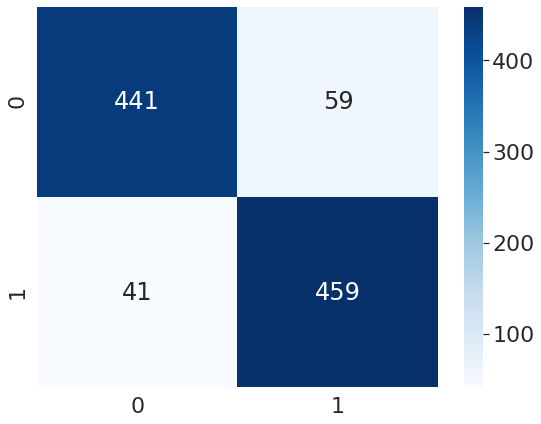

In [17]:
cfm=confusion_matrix(label,pred)
plt.figure(figsize = (9,7))
sns.set(font_scale=2)
sns.heatmap(np.int16(cfm), annot=True,cmap='Blues',fmt='g')
plt.show()

## ROC curve

In [0]:
from sklearn.metrics import roc_curve, auc

In [11]:
fpr, tpr, ths = roc_curve(label,outs[:,1])
aucval = auc(fpr, tpr)
aucval

0.9617039999999999

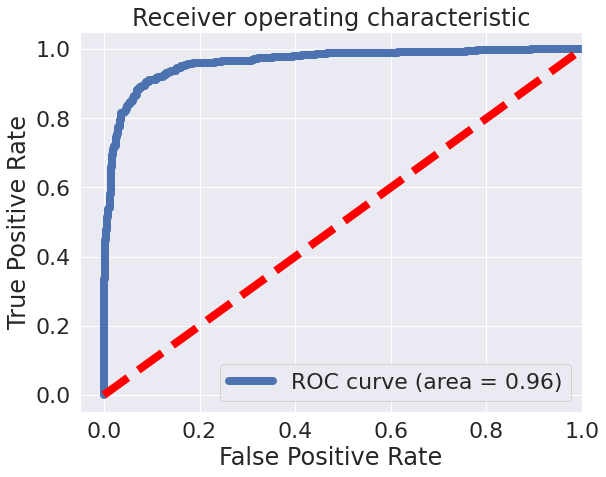

In [12]:
plt.figure(figsize=(9,7))
plt.plot(fpr, tpr, 
         lw=8, label='ROC curve (area = %0.2f)' % aucval)
plt.plot([0, 1], [0, 1], color='red', lw=8,linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()